# **Setup & Spark Installation**

In [51]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


Download and install the spark with hadoop

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

Set the environment path

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

Install and import **findspark** to locate the spark

In [6]:
!pip install -q findspark
import findspark
findspark.init()

Create a SparkSession

In [202]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .config('spark.submit.deployMode', 'client') \
        .getOrCreate()

# **Download & Read Sample File**

Download the parquet file

In [188]:
!gsutil cp gs://test_170829/example.parquet.gz /tmp/exercise.parquet.gz

Copying gs://test_170829/example.parquet.gz...
/ [1 files][ 11.8 MiB/ 11.8 MiB]                                                
Operation completed over 1 objects/11.8 MiB.                                     


In [21]:
!tar xvf /tmp/exercise.parquet.gz


gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now


Extract the Gzip file

Read the parquet file into Spark Dataframe




In [189]:
df = spark.read.parquet("/tmp/exercise.parquet")

Check the content of  Spark Dataframe

In [191]:
df.summary().show()

+-------+-----------------+-----------------+---------------------------+-----------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|               id|      document_id|orchestration_extraction_id|content_extraction_type|extractor_version|        text_content|              tables|             ocr_obj|      entity_mapping|        doc_checksum|
+-------+-----------------+-----------------+---------------------------+-----------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|              900|              900|                        900|                    900|              900|                 900|                 900|                 900|                 900|                 900|
|   mean|743.2777777777778|744.7577777777777|                       null|                   null|2.099999999999967| 

In [192]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- document_id: long (nullable = true)
 |-- orchestration_extraction_id: string (nullable = true)
 |-- content_extraction_type: string (nullable = true)
 |-- extractor_version: double (nullable = true)
 |-- text_content: string (nullable = true)
 |-- tables: string (nullable = true)
 |-- ocr_obj: string (nullable = true)
 |-- entity_mapping: string (nullable = true)
 |-- doc_checksum: string (nullable = true)
 |-- created_at: timestamp (nullable = true)



# **Data Processing**

Assuming Requirement is to simply find number of tables. Splitting by text **cells** minus 1 will give number of tables. 
Ideal way would be to parse array of json in column and calculate length of array



## Adding column num_of_tables

In [206]:
import pyspark.sql.functions as func
df3 = df.withColumn('num_of_tables', func.size(func.split(func.col('tables'), 'cells'))-1)
df3.show(5)

+----+-----------+---------------------------+-----------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+
|  id|document_id|orchestration_extraction_id|content_extraction_type|extractor_version|        text_content|              tables|             ocr_obj|      entity_mapping|        doc_checksum|          created_at|num_of_tables|
+----+-----------+---------------------------+-----------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+
| 354|        354|       41b5060f-4b3b-40b...|        form_recognizer|              2.1|{"page-0": ["INVO...|[[{"page_number":...|[{"page_number": ...|{"BillingAddress"...|d1436d292bd13909b...|2021-10-29 19:02:...|            3|
| 684|        686|       732939ed-fd39-47c...|        form_recognizer|              

## Adding column num_of_pages

In [207]:
df4  = df3.withColumn('num_of_pages', func.size(func.split(func.col("text_content"), r"page\-")) - 1)
df4.show(5)

+----+-----------+---------------------------+-----------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+------------+
|  id|document_id|orchestration_extraction_id|content_extraction_type|extractor_version|        text_content|              tables|             ocr_obj|      entity_mapping|        doc_checksum|          created_at|num_of_tables|num_of_pages|
+----+-----------+---------------------------+-----------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+------------+
| 354|        354|       41b5060f-4b3b-40b...|        form_recognizer|              2.1|{"page-0": ["INVO...|[[{"page_number":...|[{"page_number": ...|{"BillingAddress"...|d1436d292bd13909b...|2021-10-29 19:02:...|            3|           1|
| 684|        686|       732939e

Create Temporary View from dataframe

In [208]:
df4.createOrReplaceTempView("Documents")


## Adding Column entity and in_text_content

Assumption: Column **entity_mapping** has VendorName and check the occurence of same in column column **text_content**

In [209]:
df5 = spark.sql("select *, position(get_json_object(entity_mapping,'$.VendorName.value'),text_content) as in_text_content, get_json_object(entity_mapping,'$.VendorName.value') as entity  from Documents")

In [211]:
df5.show()

+----+-----------+---------------------------+-----------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+------------+---------------+--------------------+
|  id|document_id|orchestration_extraction_id|content_extraction_type|extractor_version|        text_content|              tables|             ocr_obj|      entity_mapping|        doc_checksum|          created_at|num_of_tables|num_of_pages|in_text_content|              entity|
+----+-----------+---------------------------+-----------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+------------+---------------+--------------------+
| 354|        354|       41b5060f-4b3b-40b...|        form_recognizer|              2.1|{"page-0": ["INVO...|[[{"page_number":...|[{"page_number": ...|{"BillingAdd

## Saving the file in partitioned format

Output can be made more efficient by cleansing entity name.
Eg: **Remove white spaces, special characters, lowercasing the name**

In [212]:
df5.write.partitionBy('entity').mode('overwrite').format("csv").option('path','/output/').save()

In [222]:
!ls -lrt /output | tail -5

drwxr-xr-x 2 root root 4096 Mar 15 19:13 entity=shi
drwxr-xr-x 2 root root 4096 Mar 15 19:13 entity=thechefsWAREHOUSE
drwxr-xr-x 2 root root 4096 Mar 15 19:13 entity=usbank.
drwxr-xr-x 2 root root 4096 Mar 15 19:13 entity=verizony
-rw-r--r-- 1 root root    0 Mar 15 19:13 _SUCCESS


**Output Directory**
For demo, it has been output to local but same can be achived through S3 or GCS. Also, by simply modifying the format , output can be in parquet instead of csv.

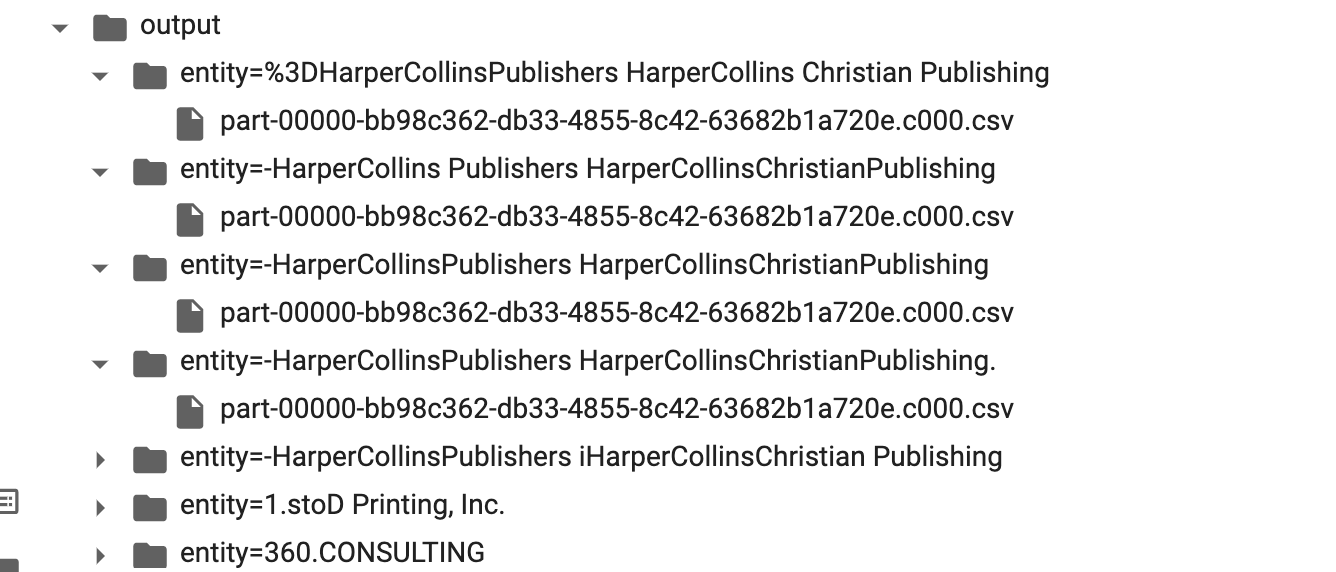

# **Improvement**: 
Processed can be improved if we know 

*   Enitity Definition: What is Entity? Examples will really help to understand it.
*   Bit more description about the structure will help to parse it better. Eg: What does each field mean
*   Different assumptions has been made to implement. And each step can be achived using different technique. For instance, this whole exercise can be done in native python rather than pyspark.
*   Also, in additon to enity partitioning, few other columns like month can be used to better create time series.

